# Squared Exponential kernel Gaussian process - PriorVAE


This is a demo notebook to showcase the usage of PriorVAE model on a Gaussian process dataset which is generated using a Squared-Exponential kernel.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
import random as rnd
import time

import numpy as np 
import matplotlib.pyplot as plt 

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)

#JAX
import jax
import flax
from jax.tree_util import tree_map
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from jax import random
import jax.numpy as jnp

# PyTorch
import torch
import torch.utils.data as data

# print versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

sys.path.append("..")  # TODO: remove this later, it should be from the installed package.

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.losses import kl_divergence, scaled_sum_squared_loss
from priorCVAE.utility import create_data_loaders
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import GPDataset

import jax.config as config
config.update("jax_enable_x64", True)

Pytorch version:  2.0.1
Numpyro version:  0.12.1
JAX version:      0.4.12
Flax version:     0.6.10
Optax version:    0.1.5
Pythorch version: 3.10.11


### Setup arguments

In [2]:
args = {"seed": 0,
        
        # data
        "num_data": 4000,
        
        # architecture
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 100,
        "num_epochs": 200,
        "vae_var": 1, 

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

### Generate data


In [3]:
train_set = GPDataset(n_data=args["input_dim"], n_samples=args["num_data"], lengthscale=0.2)  
val_set   = GPDataset(n_data=args["input_dim"], n_samples=args["num_data"], lengthscale=0.2)  
test_set  = GPDataset(n_data=args["input_dim"], n_samples=args["num_data"], lengthscale=0.2)  

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, True, True],
                                                            batch_size=args["batch_size"])

# these lines are VERY slow and produce MANY warnings - consider removing them
train_loader_iter = iter(train_loader)
val_loader_iter   = iter(val_loader)
test_loader_iter  = iter(test_loader)

In [52]:
test_set.shape

AttributeError: 'GPDataset' object has no attribute 'shape'

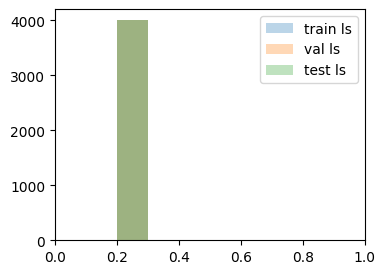

In [4]:
# check: what lengthscales are we generating? 

ls_train_set = train_set.ls
ls_val_set   = val_set.ls
ls_test_set  = test_set.ls

plt.figure(figsize=(4,3))
plt.hist(ls_train_set[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set[:, 0],   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()


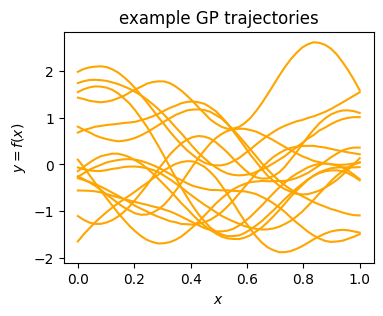

In [5]:
# check: what trajectories are we generating?

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')

plt.show()

### VAE Model

In [6]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
batch_size  = args["batch_size"]
num_data    = args["num_data"] 
num_samples = args["num_samples"]
num_epochs  = args["num_epochs"]
vae_var     = args["vae_var"]

### Training loop

In [7]:
@jax.jit
def train_step(state, batch, z_rng):
    def loss_fn(params, z_rng):
        _, y, _ = batch 
        y_hat, z_mu, z_logvar = model.apply({'params': params}, y, z_rng) 
        rcl_loss = scaled_sum_squared_loss(y_hat, y, vae_var)
        kld_loss = kl_divergence(z_mu, z_logvar)
        loss = rcl_loss + kld_loss
        return loss
    
    grads = jax.grad(loss_fn)(state.params, z_rng)
    return state.apply_gradients(grads=grads), loss_fn(state.params, z_rng)

In [8]:
@jax.jit
def eval(state, batch, z_rng):
    def loss_fn(params, z_rng):
        _, y, _ = batch 
        y_hat, z_mu, z_logvar = model.apply({'params': params}, y, z_rng) 
        rcl_loss = scaled_sum_squared_loss(y_hat, y, vae_var)
        kld_loss = kl_divergence(z_mu, z_logvar)
        loss = rcl_loss + kld_loss
        return loss
    
    return loss_fn(state.params, z_rng)

In [9]:
# define models
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

# initialise parameters
key = jax.random.PRNGKey(0) 
rng, z_key, eval_key = random.split(key, 3)

batch_init = next(val_loader_iter) # batch[0] - x, batch[1] - y, batch[2] - c
_, y, _ = batch_init
params = model.init(rng, y, key)['params']

# optimizer
optimizer = optax.adam(learning_rate=0.001)

# store training state
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

_loss_train = []
_loss_test = []

t_start = time.time()

for epoch in range(num_epochs):
    # Training phase
    for _, batch_train in enumerate(train_loader):
        z_key, key = random.split(z_key)
        state, loss_train = train_step(state, batch_train, key)
        _loss_train.append(loss_train)

    # Test phase
    for _, batch_test in enumerate(test_loader):

        eval_key, key = random.split(eval_key)
        loss_test = eval(state, batch_test, key)
        _loss_test.append(loss_test)

    if epoch % 10 == 0:  
        print(f'[{epoch + 1:5d}] training loss: {loss_train:.3f}, test loss: {loss_test:.3f}')

t_elapsed = time.time() - t_start

print(f'Training of {num_epochs} epochs took {round(t_elapsed)} seconds')

assert len(_loss_train) == num_epochs * num_data // batch_size


[    1] training loss: 2898.123, test loss: 2626.246
[   11] training loss: 1191.850, test loss: 1224.126
[   21] training loss: 932.903, test loss: 907.645
[   31] training loss: 793.955, test loss: 824.297
[   41] training loss: 793.064, test loss: 772.276
[   51] training loss: 732.642, test loss: 792.073
[   61] training loss: 749.632, test loss: 791.464
[   71] training loss: 708.318, test loss: 710.517
[   81] training loss: 779.827, test loss: 767.008
[   91] training loss: 750.564, test loss: 715.676
[  101] training loss: 746.522, test loss: 754.434
[  111] training loss: 767.892, test loss: 726.945
[  121] training loss: 755.824, test loss: 760.797
[  131] training loss: 766.615, test loss: 710.589
[  141] training loss: 771.105, test loss: 737.596
[  151] training loss: 751.906, test loss: 765.360
[  161] training loss: 751.830, test loss: 751.512
[  171] training loss: 719.191, test loss: 770.939
[  181] training loss: 760.138, test loss: 747.236
[  191] training loss: 733.

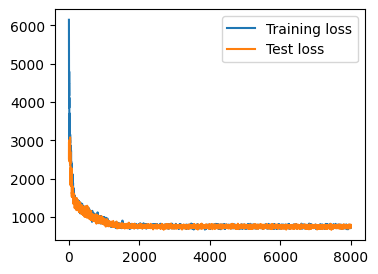

In [10]:
plt.figure(figsize=(4,3))
plt.plot(range(len(_loss_train)), _loss_train, label = 'Training loss')
plt.plot(range(len(_loss_test)), _loss_test, label = 'Test loss')
plt.legend()

#### What have we learnt?

(100, 30)
(100, 50)


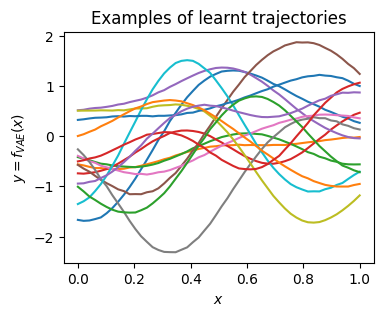

In [11]:
# Get trained decoder params
decoder_params = state.params['decoder']

rng, z_rng, init_rng = random.split(key, 3)

# latents as input
z = random.normal(z_rng, (batch_size, latent_dim))
print(z.shape)

# create decoder
decoder = MLPDecoder(hidden_dim, out_dim)

# apply decoder with trained parameters on the data
out = decoder.apply({'params': decoder_params}, z)             
print(out.shape)

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(train_set.x[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

#### Visual diagnostics

### Inference with MCMC

#### Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

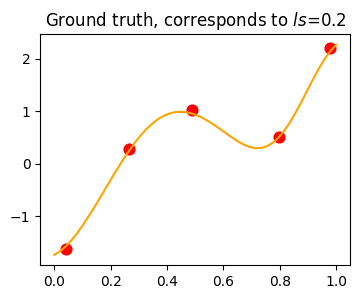

In [12]:
x = train_set[0][0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=args["true_ls"], variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# choose indices of data points for inference
obs_idx = jnp.array([2, 13, 24, 39, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

In [13]:
# add data to args

args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

#### Nupmyro model

In [14]:
mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -1.69      0.22     -1.70     -2.05     -1.34  17941.77      1.00
      f[1]     -1.67      0.22     -1.68     -2.02     -1.31  17578.79      1.00
      f[2]     -1.60      0.21     -1.62     -1.94     -1.26  17309.55      1.00
      f[3]     -1.53      0.21     -1.54     -1.86     -1.19  16807.90      1.00
      f[4]     -1.41      0.20     -1.43     -1.74     -1.09  16811.34      1.00
      f[5]     -1.29      0.19     -1.30     -1.60     -0.97  16294.28      1.00
      f[6]     -1.12      0.19     -1.13     -1.42     -0.80  16345.39      1.00
      f[7]     -0.93      0.19     -0.94     -1.22     -0.61  16464.19      1.00
      f[8]     -0.74      0.19     -0.75     -1.03     -0.43  16447.09      1.00
      f[9]     -0.51      0.18     -0.52     -0.80     -0.20  17388.30      1.00
     f[10]     -0.28      0.19     -0.29     -0.59      0.03  18168.04      1.00
     f[11]     -0.06      0

Text(0.5, 1.0, 'PriorVAE inference')

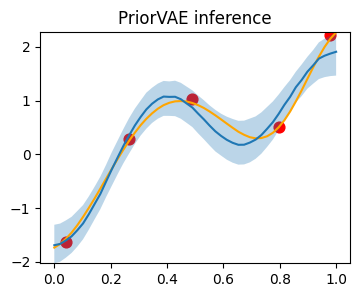

In [15]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorVAE inference')

In [53]:
state

TrainState(step=Array(8000, dtype=int64, weak_type=True), apply_fn=VAE(
    # attributes
    encoder = MLPEncoder(
        # attributes
        hidden_dim = 40
        latent_dim = 30
    )
    decoder = MLPDecoder(
        # attributes
        hidden_dim = 40
        out_dim = 50
    )
), params=FrozenDict({
    decoder: {
        dec_hidden: {
            bias: Array([ 0.15932864, -0.01542185,  0.08543879,  0.03971313,  0.07108048,
                   -0.09268918,  0.02405665,  0.00444034, -0.01695892, -0.08231805,
                    0.02164011, -0.02689396,  0.01233956, -0.1313594 ,  0.01058913,
                    0.04471288, -0.08326395,  0.07263207,  0.03149236, -0.09571192,
                   -0.00129142,  0.06887013, -0.02714317,  0.07960729, -0.02896697,
                   -0.02470371,  0.04513201,  0.11033174, -0.06776472,  0.04053175,
                    0.0539152 ,  0.07540999, -0.06904516,  0.01749209,  0.00455576,
                   -0.00091886, -0.03339111,  0.0189826 , 

In [60]:
import pandas as pd
data_dict = {}

# Since x, y, and ls are 2D arrays, we'll flatten them to 1D for the DataFrame
data_dict['x'] = train_set.x.flatten()
data_dict['y'] = train_set.y.flatten()
data_dict['lengthscale'] = train_set.ls

# df = pd.DataFrame(data_dict)
train_set.ls.shape

(4000, 1)

In [17]:
from priorCVAE.diagnostics import *

In [28]:
grid = jnp.linspace(0, 1, 50) 
K = SquaredExponential(lengthscale=args["true_ls"], variance=1.)(grid,grid)

In [44]:
# latents as input
z = random.normal(z_rng, (10000, latent_dim))
print(z.shape)

# create decoder
decoder = MLPDecoder(hidden_dim, out_dim)

# apply decoder with trained parameters on the data
vae_realizations = decoder.apply({'params': decoder_params}, z)  

(10000, 30)


In [45]:
frobenius_norm_of_kernel_diff(vae_realizations, K)

2.566772350755779

In [47]:
mean_bootstrap_interval_contains_zero(vae_realizations)

(array([ 0.00213135,  0.00345788,  0.00406936,  0.00570063,  0.00705492,
         0.00817174,  0.00943645,  0.01014801,  0.01040018,  0.00969282,
         0.00985905,  0.0088767 ,  0.00753301,  0.00653214,  0.00575276,
         0.00433416,  0.00358189,  0.00276472,  0.00223694,  0.00125953,
         0.00051097, -0.00057588, -0.00219338, -0.00410798, -0.0075143 ,
        -0.01086562, -0.01389999, -0.01729767, -0.02095809, -0.02392042,
        -0.0253731 , -0.02662606, -0.02650613, -0.0243044 , -0.02165669,
        -0.01804365, -0.01301786, -0.00789504, -0.00145379,  0.0037536 ,
         0.00835789,  0.01198988,  0.01441361,  0.01572608,  0.0155042 ,
         0.01353761,  0.0096455 ,  0.0060893 ,  0.00171756, -0.00200176]),
 array([0.0306885 , 0.03258166, 0.03385685, 0.0353198 , 0.03704865,
        0.03887412, 0.04033569, 0.04124058, 0.04187317, 0.04101651,
        0.04060935, 0.03966426, 0.03877291, 0.03790652, 0.03665487,
        0.03547716, 0.0349591 , 0.03458813, 0.03447899, 0.033428

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


n = 50

dist_to_cov = defaultdict(list)
vae_covariance = compute_empirical_covariance(vae_realizations)
for i in range(n):
    for j in range(i,n):
        dist_to_cov[abs(j-i)].append(vae_covariance[i][j])
    

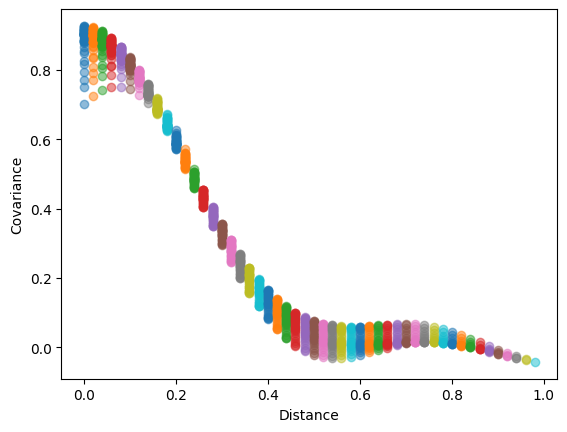

In [49]:
import matplotlib.pyplot as plt


for distance, covariances in dist_to_cov.items():
    # Repeat the current distance for as many times as there are covariances
    distances = [distance/50] * len(covariances)
    plt.scatter(distances, covariances, alpha=0.5)
    
plt.xlabel('Distance')
plt.ylabel('Covariance')
plt.show()

In [67]:
from priorCVAE.diagnostics import plot_realizations

(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': 'Examples of learnt trajectories'}, xlabel='$x$', ylabel='$y=f_{VAE}(x)$'>)

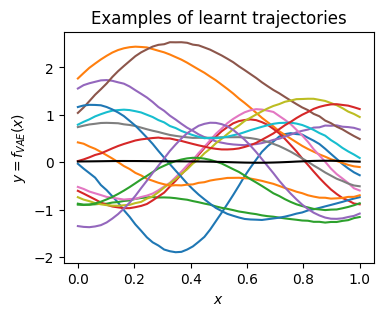

In [68]:
plot_realizations(grid, vae_realizations)

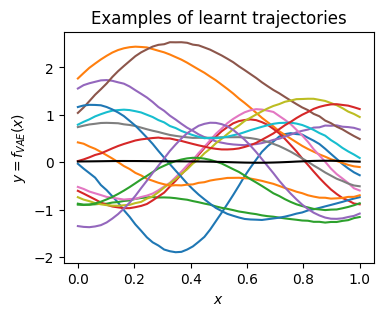

In [50]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(train_set.x[0], vae_realizations[i,:])
    
ax.plot(train_set.x[0], vae_realizations.mean(axis=0), c='black')
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

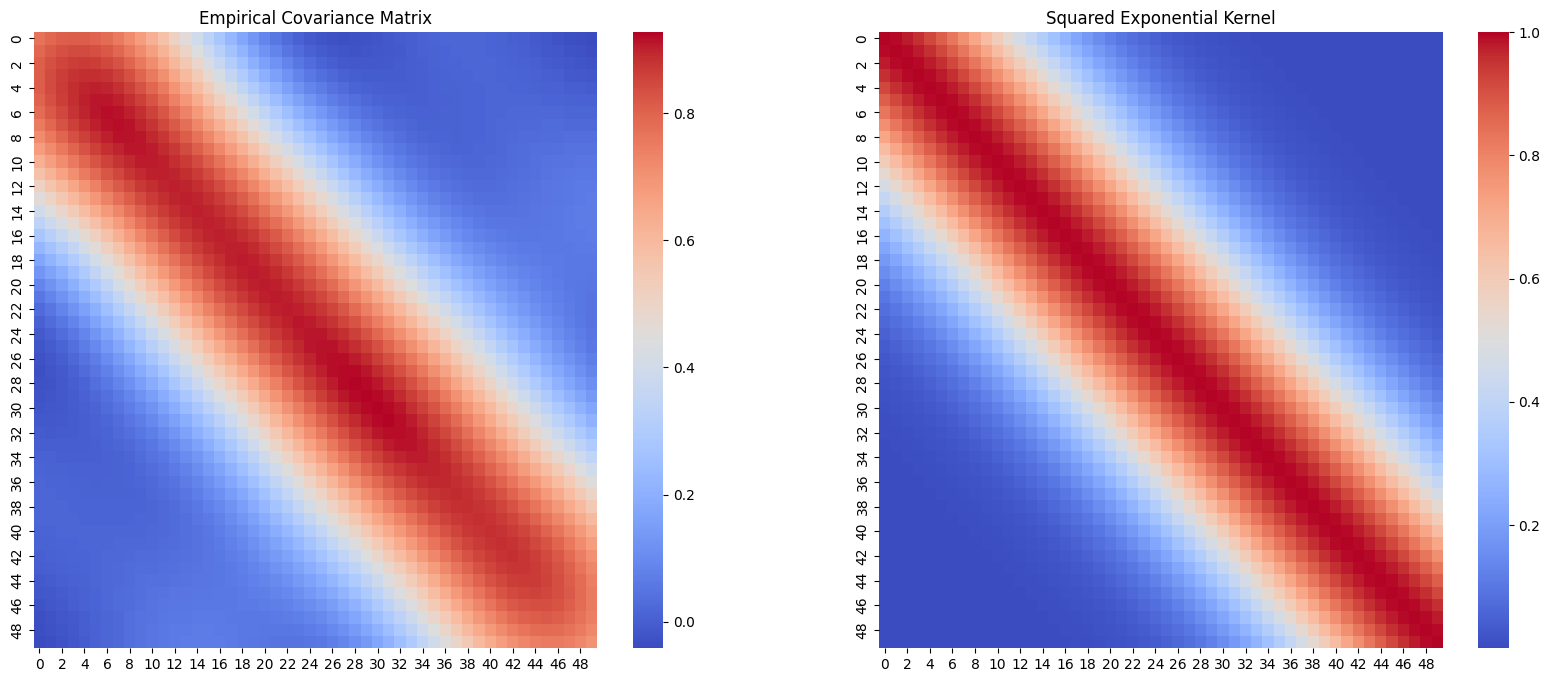

AttributeError: module 'seaborn' has no attribute 'fig'

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.heatmap(vae_covariance, annot=False, fmt='g', cmap='coolwarm', ax=ax[0])

ax[0].set_title('Empirical Covariance Matrix')

sns.heatmap(K, annot=False, fmt='g', cmap='coolwarm', ax=ax[1])
ax[1].set_title('Squared Exponential Kernel')

plt.show()
sns.fig

In [70]:
from priorCVAE.diagnostics import plot_heatmap

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Empirical Covariance Matrix'}>)

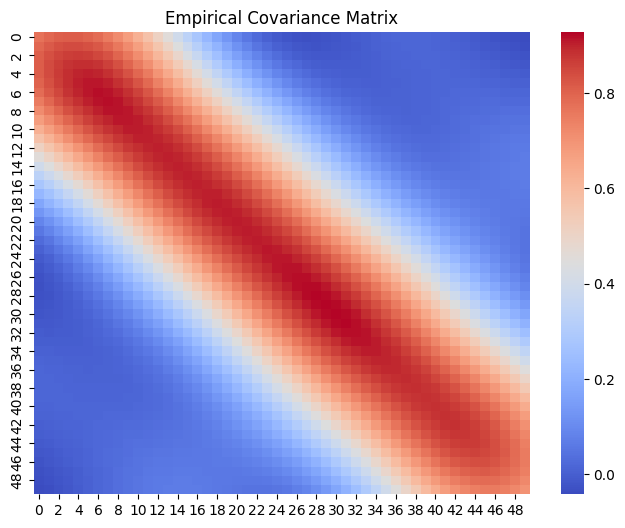

In [89]:
plot_heatmap(vae_covariance,'ECM')


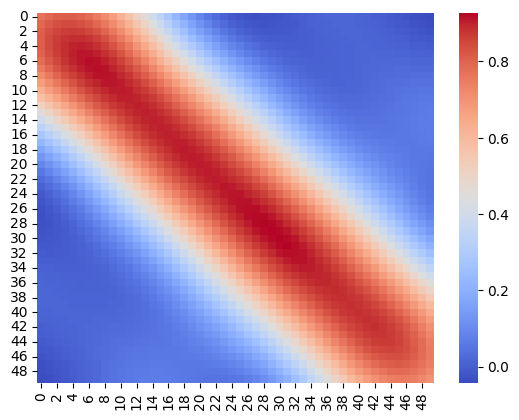

In [75]:
a = sns.heatmap(vae_covariance, annot=False, fmt='g', cmap='coolwarm')

In [77]:
a.fig()


AttributeError: 'Axes' object has no attribute 'fig'